# Facial Gender Classification Using CNNs: A Transfer Learning Approach
An independent project by Curtis Gribben

## Table of Contents
- Overview
 
- Importing the Dataset
 
- 2 Importing the Pre-trained Base
 
- 3 Constructing and Training the Model

- 4 Analysis

- 5 Training and Analysing Two Alternative Models

- 6 Results of Model Comparison

- 7 Making Predictions
 
- Conclusions

## Overview

#### Background
**Transfer learning** has proved an immensely powerful technique in the context of building deep models using a limited dataset and/or limited computational resources. An alternative to training a model from scratch, transfer learning leverages knowledge from solving one task to improve performance on a different but related task. Within the context of Computer Vision, **Convolutional Neural Networks (CNNs)** can benefit greatly from the technique, as hierarchical features extracted by the convolutional base can be relevant for use in other tasks.

Here, I aim to build a facial recognition classifier to identify images as either "Male" or "Female". I have chosen to do so by utilizing the convolutional base of the **"VGGFace"** model as a **pre-trained base** within my model, on top of which I will build and train my own custom classifier of dense layers. VGGFace is a CNN model that is specifically trained for face recognition tasks, having been designed to recognize and classify faces in images.

It is predicted that these two tasks (gender classification and general facial recognition) might share many underlying patterns or features which may be exploited to train an effective classifier. Thus, by using the pre-trained base of the VGGFace model, we should be able to successfully leverage the power of transfer learning and build a deep learning model capable of carrying out the task of facial gender classification to a high level of predictive performance.

#### The dataset

The dataset consists of 20,000 celebrity face images, where the "Male" class is labelled "1", and "Female" labelled  "0". Each image is zoomed into and centred upon the subject's face. Due to limited computational resources, I chose to extract just a subset of **6,500 images**, where I implemented a Train/Validation/Test split of 5000/750/750.

CelebFace dataset collated by https://www.kaggle.com/jessicali9530. <br>
Dataset preprocessed at and downloaded from https://www.kaggle.com/datasets/ashishjangra27/gender-detection-20k-images-celeba.

#### Model comparison

I will also be testing the performance of two more CNNs with different convolutional bases, in addition to that built upon the VGGFace pre-trained base.

Firstly, I will build my own basic, **untrained** convolutional base. It is predicted that this model will perform significantly worse than that with the VGGFace pre-trained base, as it will only be able to use the data at hand here to learn feature extraction, as opposed to the large dataset of images used in training VGGFace.

Secondly, I will investigate the effect of using the pre-trained base of the more generalised **"VGG16"** model, which is trained on the **ImageNet** database (1,000 images each of the 1,000 most common objects). Note that the architecture ("VGG16" architecture) is the same as the VGGFace model; the models simply differ in their learned weights. It is predicted that, while still having learned to extract many useful features, the VGG16 base will not perform quite as well as the VGGFace base, which is trained on a task considerably more similar to that of this project than the VGG16 model.

Thus, the three models investigated in this project are summarised below:

<br>

- **"Custom":** Architecture = Custom, Weights = Untrained

<br>

- **"VGG16":** Architecture = VGG16, Weights = ImageNet

<br>

- **"VGGFace":** Architecture = VGG16, Weights = VGGFace

<!-- [[Importing the Dataset]] -->
## 1 Importing the Dataset

#### Downgrading Tensorflow and Keras to versions compatible with Keras VGGFace v0.6

In [ ]:
!pip install tensorflow==2.12
!pip install keras==2.12

#### Loading dependencies

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow
from keras_vggface.vggface import VGGFace
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras_vggface.utils import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

#### Specifying Batch Size and Image Size

In [46]:
batch_size = 64
image_size = 224

#### Using the Keras ImageDataGenerator to create a Training Data Generator

In [62]:
train_datagen = ImageDataGenerator(
    rescale=1./255,         
    rotation_range=20,      
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    shear_range=0.2,        
    zoom_range=0.2,         
    horizontal_flip=True,   
    fill_mode='nearest')

Rescaling the image and implementing data augmentation.

#### Creating a Validation Data Generator

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)

#### Creating a Test Data Generator

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

#### Importing the Training, Validation, and Test datasets

In [227]:
local_directory = 'C:/Users/curtu/OneDrive - Durham University/Documents'

train_folder = os.path.join(local_directory, 'gender_train')
val_folder = os.path.join(local_directory, 'gender_val')
test_folder = os.path.join(local_directory, 'gender_test')

#### Configuring the generators

In [528]:
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_folder,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(image_size, image_size),
    batch_size=750,
    class_mode='binary')

Found 5000 images belonging to 2 classes.
Found 750 images belonging to 2 classes.
Found 750 images belonging to 2 classes.


#### Viewing a sample image from the training set

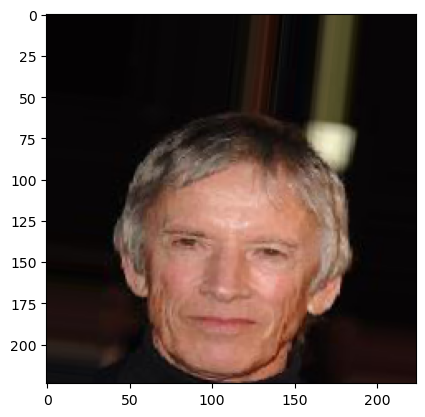

In [482]:
train_images, train_labels = train_generator.next()

plt.clf()
plt.imshow(train_images[0])
plt.show()

<!-- [[Importing the Pre-trained Base]] -->
## 2 Importing the Pre-trained Base

#### Importing using the Keras "VGGFace" class

In [483]:
pretrained_model = VGGFace(model='vgg16', weights='vggface', include_top=False, input_shape=(image_size, image_size, 3), pooling='avg')

Note that as the pre-trained model is imported with global average pooling, the inclusion of a flatten layer following the convolutional base is unnecessary.

#### Freezing the layers of the pretrained model

In [484]:
for layer in pretrained_model.layers:
    layer.trainable = False

#### Displaying pre-trained base architecture

In [486]:
pretrained_model.summary()

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

As the base has now been frozen, there are no trainable parameters.

<!-- [[Constructing and Training the Model]] -->
## 3 Constructing and Training the Model

#### Constructing the model

In [407]:
model = Sequential([

    pretrained_model,
    
    Dense(256, activation='relu'),
    
    Dense(128, activation='relu'),
    
    Dropout(0.4),

    Dense(1, activation='sigmoid')
])

#### Displaying the model architecture - important to talk about

In [361]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vggface_vgg16 (Functional)  (None, 512)               14714688  
                                                                 
 dense_78 (Dense)            (None, 256)               131328    
                                                                 
 dense_79 (Dense)            (None, 128)               32896     
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_80 (Dense)            (None, 1)                 129       
                                                                 
Total params: 14,879,041
Trainable params: 164,353
Non-trainable params: 14,714,688
_________________________________________________________________


There are now trainable parameters - these belong to the classifier section of the model.

#### Compiling the model

In [408]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

#### Implementing early stopping

In [409]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

#### Training the model

In [410]:
history = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stopping])

Epoch 1/10
79/79 [==============================] - 602s 8s/step - loss: 0.3921 - accuracy: 0.8710 - val_loss: 0.1318 - val_accuracy: 0.9547
Epoch 2/10
79/79 [==============================] - 563s 7s/step - loss: 0.1358 - accuracy: 0.9490 - val_loss: 0.0922 - val_accuracy: 0.9600
Epoch 3/10
79/79 [==============================] - 562s 7s/step - loss: 0.1143 - accuracy: 0.9562 - val_loss: 0.0872 - val_accuracy: 0.9653
Epoch 4/10
79/79 [==============================] - 561s 7s/step - loss: 0.1111 - accuracy: 0.9554 - val_loss: 0.1182 - val_accuracy: 0.9533
Epoch 5/10
79/79 [==============================] - 555s 7s/step - loss: 0.1019 - accuracy: 0.9590 - val_loss: 0.0819 - val_accuracy: 0.9653
Epoch 6/10
79/79 [==============================] - 554s 7s/step - loss: 0.0927 - accuracy: 0.9646 - val_loss: 0.0847 - val_accuracy: 0.9693
Epoch 7/10
79/79 [==============================] - 556s 7s/step - loss: 0.0979 - accuracy: 0.9604 - val_loss: 0.0816 - val_accuracy: 0.9667
Epoch 8/10
79

Stopping after 10 epochs due to time/computational restrictions.

### Task-Specific Fine-Tuning
Note that I could have fine-tuned the base by unfreezing and running subsequent epochs, however, given how suited the base already is to the task at hand, this was not necessary. In any case, the number of trainable parameters in the base is orders of magnitude larger than the top of the model, and therefore such fine-tuning would require considerable computational effort.

Below is the code I would have run if said fine-tuning was desired:

In [ ]:
# for layer in pretrained_model.layers:
    # layer.trainable = True
    
# model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# history = model.fit(train_generator, epochs=5, validation_data=val_generator)

Note that the initial learning rate is reduced here - by using a lower learning rate, we reduce the risk of making large updates to the weights, which could lead to forgetting important features learned during the original training.

<!-- [[Analysis]] -->
## 4 Analysis

#### Plotting Loss curve and Accuracy curve

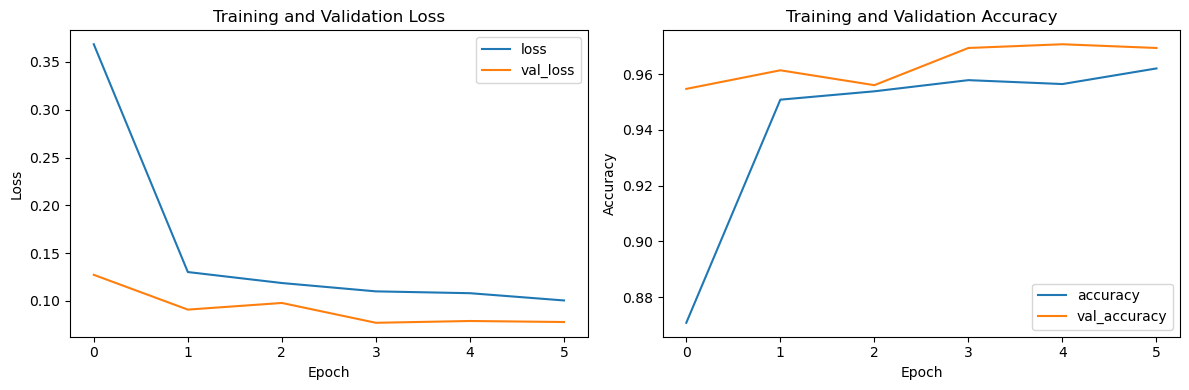

In [365]:
history_df = pd.DataFrame(history.history)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

history_df.loc[:, ['loss', 'val_loss']].plot(ax=ax1)
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

history_df.loc[:, ['accuracy', 'val_accuracy']].plot(ax=ax2)
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

These appear to be ideal loss and accuracy curves - there is no sign of overfitting during training.

#### Using validation set to determine optimal classification threshold

In [411]:
val_generator_max_batch = val_datagen.flow_from_directory(
    val_folder,
    target_size=(image_size, image_size),
    batch_size=750,
    class_mode='binary')

val_images, val_labels = val_generator_max_batch.next()

val_predictions = model.predict(val_images)

Found 750 images belonging to 2 classes.
24/24 [==============================] - 71s 3s/step


In [412]:
accuracy_scores = []

for i in np.arange(0.3, 0.71, 0.01):
    predicted_val_labels = (val_predictions > i).astype(int)
    accuracy_scores.append(accuracy_score(val_labels, predicted_val_labels))

f1_scores = []

for i in np.arange(0.3, 0.71, 0.01):
    predicted_val_labels = (val_predictions > i).astype(int)
    f1_scores.append(f1_score(val_labels, predicted_val_labels))
    
x_values = np.arange(0.3, 0.71, 0.01)

#### Plotting Accuracy, F1 Score by Classification Threshold

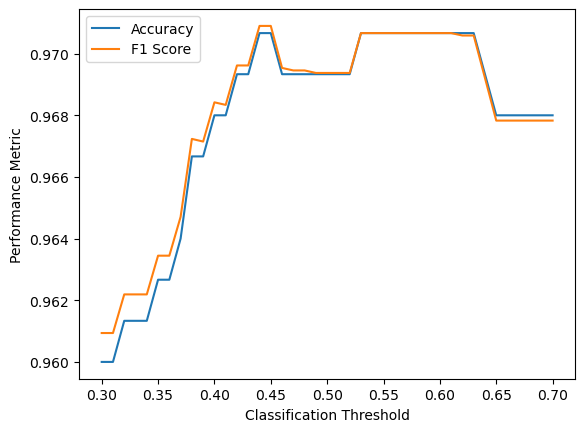

In [458]:
plt.plot(x_values, accuracy_scores, label='Accuracy')

plt.plot(x_values, f1_scores, label='F1 Score')

plt.xlabel('Classification Threshold')
plt.ylabel('Performance Metric')
plt.legend()

It appears that, given the inherent stochasticity of estimating accuracy scores where there are evidently few samples in and around the range of proposed thresholds, a large component driving fluctuations in accuracy here is chance. As a result, a threshold which gives the optimum performance metric in the validation set may not necessarily give the optimum metric in the test set.

However, we can still use this plot to inform our decision when setting the classification threshold. Although both accuracy and F1 score exhibit bimodality either side of 0.5, there is a longer run of the maximum accuracy score (and almost the maximum F1 score) from 0.53 to 0.63. Therefore, I have opted to set the classification threshold of the model to **0.58** - in the middle of this range.

In [625]:
max_accuracy, max_f1 = max(accuracy_scores), max(f1_scores)

max_accuracy_threshold_indices = [index for index, value in enumerate(accuracy_scores) if value == max_accuracy]
max_f1_threshold_indices = [index for index, value in enumerate(f1_scores) if value == max_f1]

max_accuracy_thresholds = x_values[max_accuracy_threshold_indices]
max_f1_thresholds = x_values[max_f1_threshold_indices]

In [626]:
print("Threshold for Max Accuracy:", max_accuracy_thresholds)
print("Threshold for Max F1 Score:", max_f1_thresholds)

Threshold for Max Accuracy: [0.44 0.45 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63]
Threshold for Max F1 Score: [0.44 0.45]


#### Generating predictions on test set

In [583]:
test_images, test_labels = test_generator.next()

predictions = model.predict(test_images)

24/24 [==============================] - 77s 3s/step


#### Converting predictions to binary values

In [634]:
predicted_labels = (predictions > 0.58).astype(int)

Using the classification threshold designated above.

#### Calculating Accuracy

In [635]:
test_accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Accuracy: {100*test_accuracy:.2f}%")

Accuracy: 97.07%


#### Calculating F1 Score

In [636]:
test_f1 = f1_score(test_labels, predicted_labels)
print(f"F1 Score: {test_f1:.3f}")

F1 Score: 0.971


#### Constructing a Confusion Matrix

In [637]:
conf_matrix = confusion_matrix(test_labels, predicted_labels)

#### Displaying the Confusion Matrix using a Heatmap

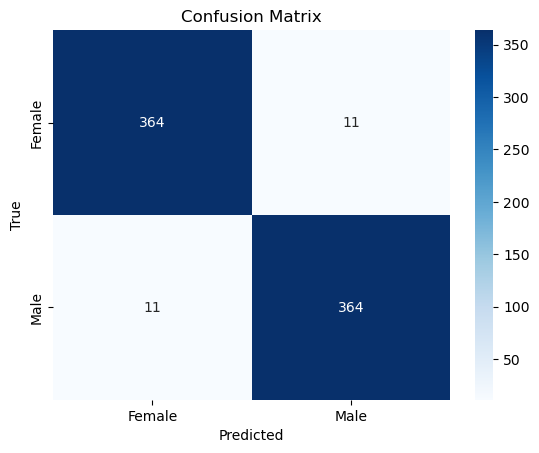

In [638]:
plt.clf()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

As it happens, the precision and recall here are equal. This is why our accuracy score and F1 score are equal - because precision and recall are equal and the classes are perfectly balanced, their harmonic mean will be equal to the accuracy score.

<!-- [[Training and Analysing Two Alternative Models]] -->
## 5 Training and Analysing Two Alternative Models

### Basic, Untrained Base

#### Carrying out comparison with basic custom convolutional base, with randomised initial weights
Note that the number of trainable parameters increases by over ten-fold compared to with transfer learning.

In [523]:
model_basic = Sequential([
    
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, 3)),
    
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    
    MaxPooling2D((2, 2)),
    
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    
    MaxPooling2D((2, 2)),
    
    GlobalAveragePooling2D(),
    
    Dense(256, activation='relu'),
    
    Dense(128, activation='relu'),
    
    Dropout(0.4),

    Dense(1, activation='sigmoid')
])

model_basic.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_basic = model_basic.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stopping])

Epoch 1/10
79/79 [==============================] - 276s 3s/step - loss: 0.6910 - accuracy: 0.5422 - val_loss: 0.6870 - val_accuracy: 0.5787
Epoch 2/10
79/79 [==============================] - 259s 3s/step - loss: 0.6471 - accuracy: 0.6294 - val_loss: 0.5657 - val_accuracy: 0.7240
Epoch 3/10
79/79 [==============================] - 272s 3s/step - loss: 0.6062 - accuracy: 0.6926 - val_loss: 0.5686 - val_accuracy: 0.7493
Epoch 4/10
79/79 [==============================] - 268s 3s/step - loss: 0.5901 - accuracy: 0.6956 - val_loss: 0.5679 - val_accuracy: 0.7133


#### Generating predictions on test set

In [652]:
test_images, test_labels = test_generator.next()

predictions_basic = model_basic.predict(test_images)

predicted_labels_basic = (predictions_basic > 0.5).astype(int)

24/24 [==============================] - 9s 364ms/step


Classification threshold being set simply to 0.5 for conciseness; fine-tuning the threshold only brings about a slight improvement in performance, and so this process has been left out here for brevity.

#### Returning Accuracy and F1 Score

In [653]:
test_accuracy_basic = accuracy_score(test_labels, predicted_labels_basic)

test_f1_basic = f1_score(test_labels, predicted_labels_basic)

In [654]:
print(f"Accuracy: {100*test_accuracy_basic:.2f}%")
print(f"F1 Score: {test_f1_basic:.3f}")

Accuracy: 72.40%
F1 Score: 0.734


### VGG16 Base with ImageNet Weights

#### Carrying out comparison with VGG16 model with general ImageNet weights

In [529]:
pretrained_model_imagenet_weights = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling='avg')

for layer in pretrained_model_imagenet_weights.layers:
    layer.trainable = False
    
model_imagenet_weights = Sequential([

    pretrained_model_imagenet_weights, 
    
    Dense(256, activation='relu'),
    
    Dense(128, activation='relu'),
    
    Dropout(0.4),

    Dense(1, activation='sigmoid')
])

model_imagenet_weights.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_imagenet_weights = model_imagenet_weights.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stopping])

Epoch 1/10
79/79 [==============================] - 596s 8s/step - loss: 0.5148 - accuracy: 0.7414 - val_loss: 0.3269 - val_accuracy: 0.8773
Epoch 2/10
79/79 [==============================] - 607s 8s/step - loss: 0.3705 - accuracy: 0.8372 - val_loss: 0.2693 - val_accuracy: 0.9053
Epoch 3/10
79/79 [==============================] - 645s 8s/step - loss: 0.3307 - accuracy: 0.8572 - val_loss: 0.2481 - val_accuracy: 0.9147
Epoch 4/10
79/79 [==============================] - 758s 10s/step - loss: 0.3196 - accuracy: 0.8636 - val_loss: 0.2430 - val_accuracy: 0.9160
Epoch 5/10
79/79 [==============================] - 668s 8s/step - loss: 0.2958 - accuracy: 0.8786 - val_loss: 0.2423 - val_accuracy: 0.9147
Epoch 6/10
79/79 [==============================] - 618s 8s/step - loss: 0.2940 - accuracy: 0.8786 - val_loss: 0.2337 - val_accuracy: 0.9133
Epoch 7/10
79/79 [==============================] - 605s 8s/step - loss: 0.2818 - accuracy: 0.8792 - val_loss: 0.2240 - val_accuracy: 0.9187
Epoch 8/10
7

#### Generating predictions on test set
Again, classification threshold being set simply to 0.5 for conciseness.

In [658]:
test_images, test_labels = test_generator.next()

predictions_imagenet_weights = model_imagenet_weights.predict(test_images)

predicted_labels_imagenet_weights = (predictions_imagenet_weights > 0.5).astype(int)

24/24 [==============================] - 73s 3s/step


#### Returning Accuracy and F1 Score

In [659]:
test_accuracy_imagenet_weights = accuracy_score(test_labels, predicted_labels_imagenet_weights)

test_f1_imagenet_weights = f1_score(test_labels, predicted_labels_imagenet_weights)

In [660]:
print(f"Accuracy: {100*test_accuracy_imagenet_weights:.2f}%")
print(f"F1 Score: {test_f1_imagenet_weights:.3f}")

Accuracy: 87.33%
F1 Score: 0.876


<!-- [[Results of Model Comparison]] -->
## 6 Results of Model Comparison

**Base:** Architecture = Custom, Weights = Untrained

**Results:** Accuracy = 72.40%, F1 Score = 0.734

<br>

**Base:** Architecture = VGG16, Weights = ImageNet

**Results:** Accuracy = 87.33%, F1 Score = 0.876

<br>

**Base:** Architecture = VGG16, Weights = VGGFace

**Results:** Accuracy = 97.07%, F1 Score = 0.971

**These results align well with initial predictions.**

<!-- [[Making Predictions]] -->
## 7 Making Predictions

#### Defining a function to show predictions

In [335]:
def make_prediction(index, show):

    def show_probability(index):
  
        if predictions[index][0] >= 0.5:
            return "Prediction: Male", f"Certainty: {round(predictions[index][0]*100,2)}%"
        else:
            return "Prediction: Female", f"Certainty: {100 - round(predictions[index][0]*100,2)}%"

    def show_image(index):
  
        plt.clf()
        plt.imshow(test_images[index])
        plt.show()
  
    if show == True:
        show_image(index)
    
    return show_probability(index)

### Returning samples and their predictions

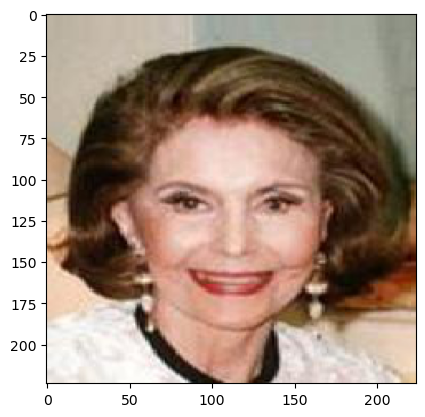

('Prediction: Female', 'Certainty: 99.99%')


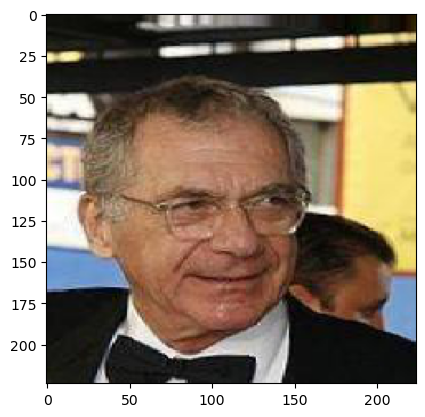

('Prediction: Male', 'Certainty: 100.0%')


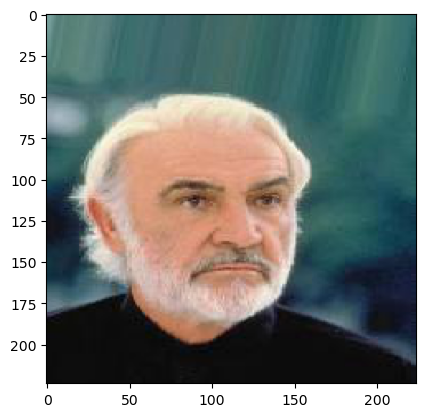

('Prediction: Male', 'Certainty: 99.72%')


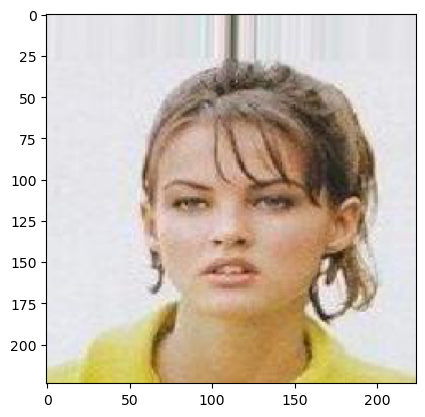

('Prediction: Female', 'Certainty: 99.91%')


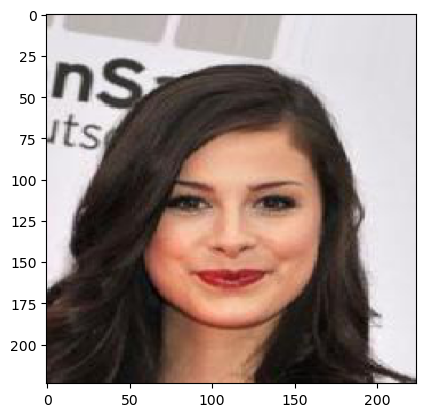

('Prediction: Female', 'Certainty: 100.0%')


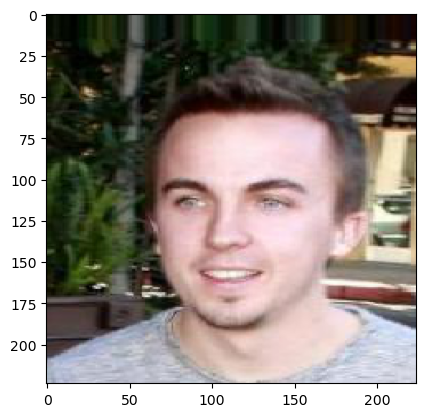

('Prediction: Male', 'Certainty: 99.98%')


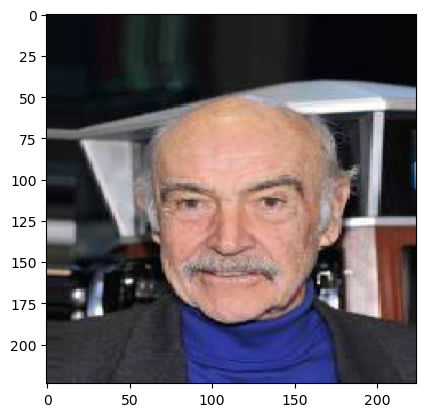

('Prediction: Male', 'Certainty: 99.96%')


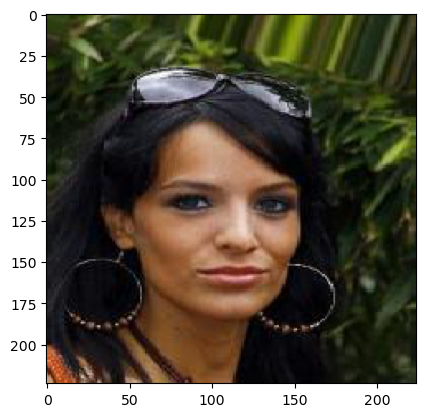

('Prediction: Female', 'Certainty: 99.31%')


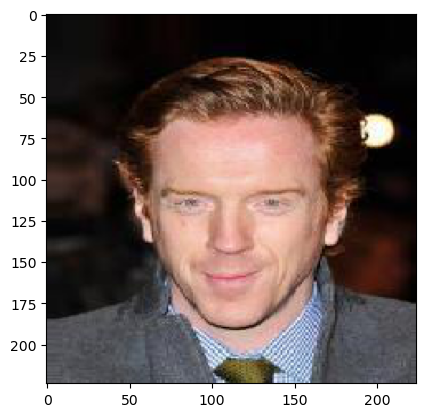

('Prediction: Male', 'Certainty: 100.0%')


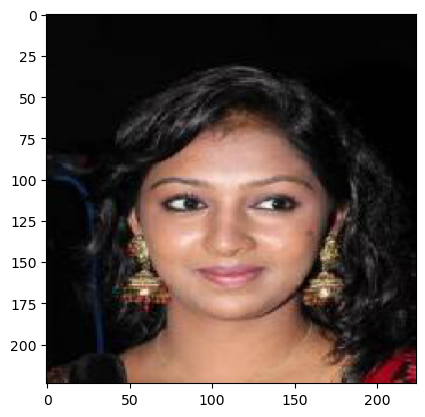

('Prediction: Female', 'Certainty: 99.97%')


In [648]:
for i in range(10):
    print(make_prediction(i, True))

These predictions are clearly correct!

### Viewing misclassified samples

#### Constructing an index list of cases where the predicted label does not match the true label

In [650]:
mismatch_indices = []

for i in range(len(test_labels)):
    if test_labels[i] != predicted_labels[i]:
        mismatch_indices.append(i)

#### Displaying all cases

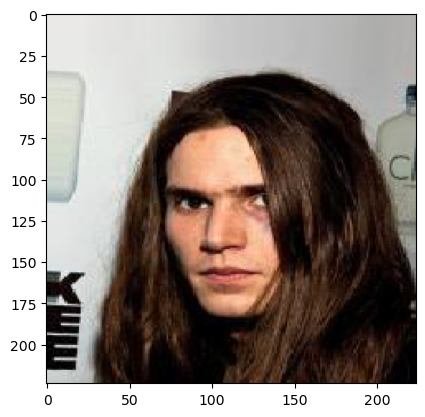

('Prediction: Male', 'Certainty: 50.54%')


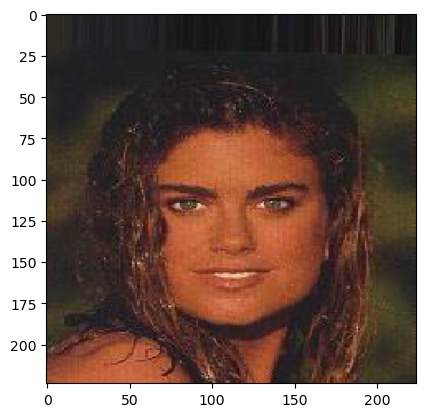

('Prediction: Female', 'Certainty: 99.3%')


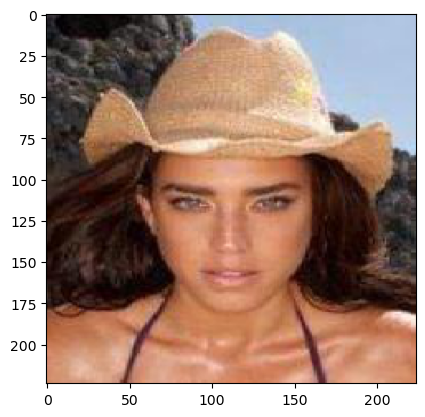

('Prediction: Male', 'Certainty: 71.4%')


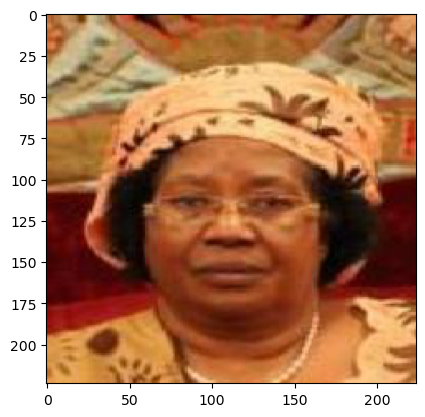

('Prediction: Male', 'Certainty: 89.61%')


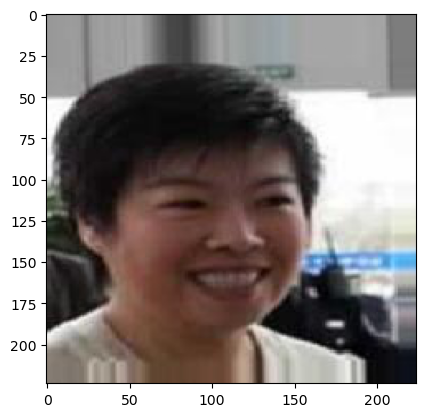

('Prediction: Male', 'Certainty: 86.87%')


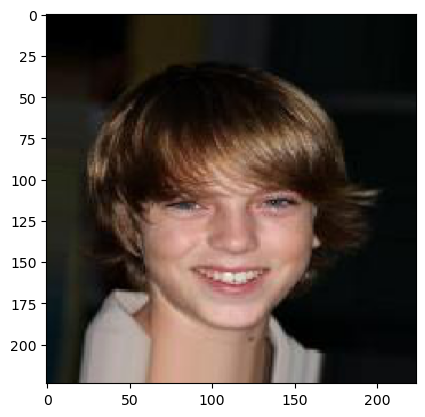

('Prediction: Female', 'Certainty: 51.65%')


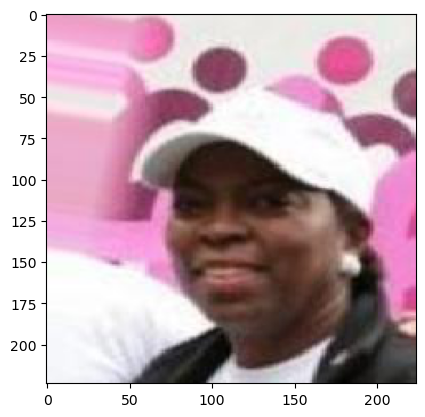

('Prediction: Male', 'Certainty: 93.16%')


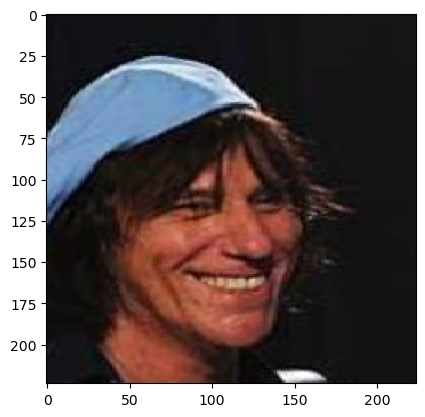

('Prediction: Female', 'Certainty: 82.7%')


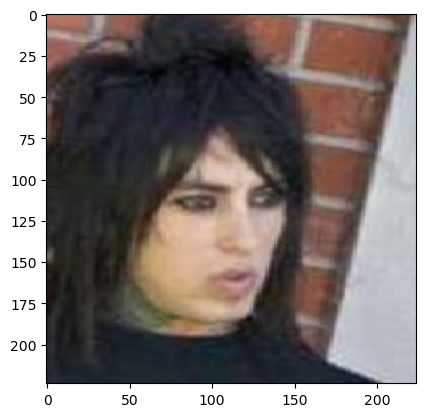

('Prediction: Female', 'Certainty: 67.1%')


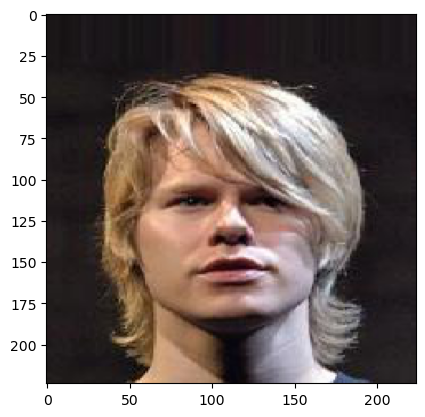

('Prediction: Female', 'Certainty: 58.83%')


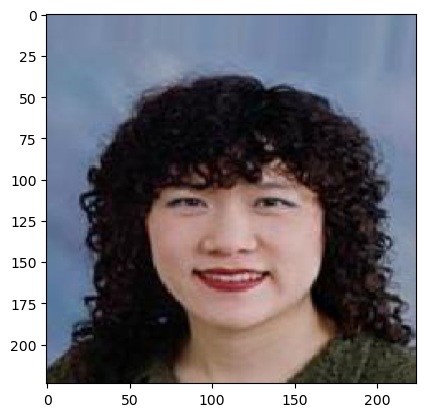

('Prediction: Male', 'Certainty: 99.52%')


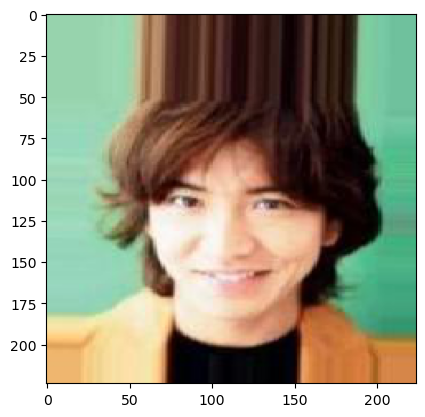

('Prediction: Female', 'Certainty: 88.03%')


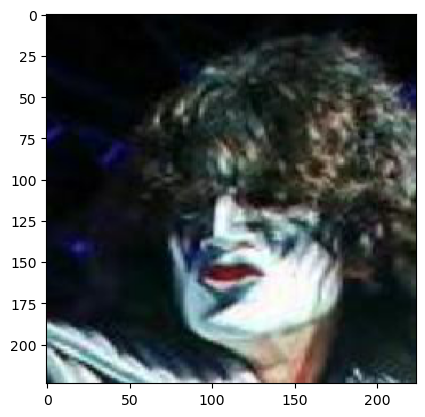

('Prediction: Male', 'Certainty: 51.02%')


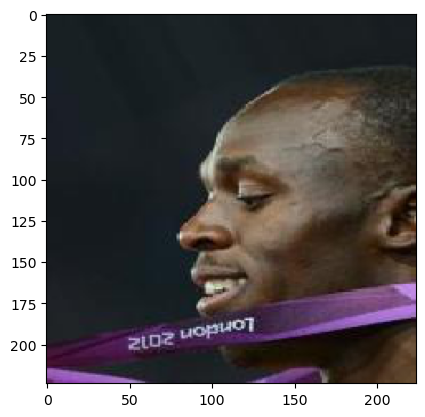

('Prediction: Male', 'Certainty: 56.87%')


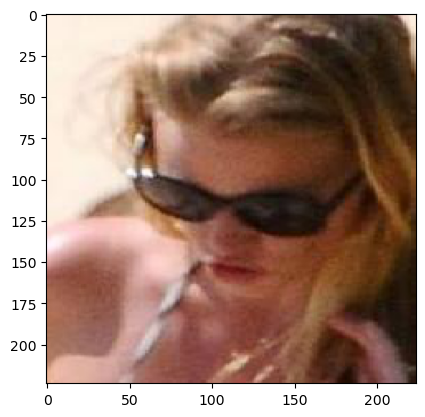

('Prediction: Male', 'Certainty: 68.99%')


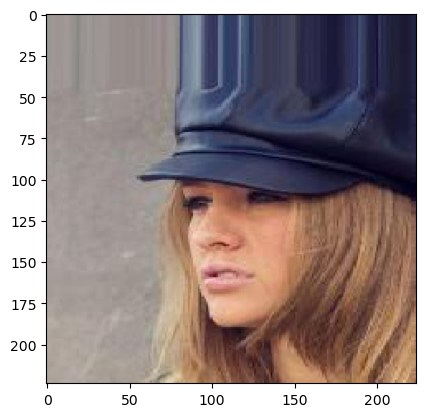

('Prediction: Male', 'Certainty: 70.81%')


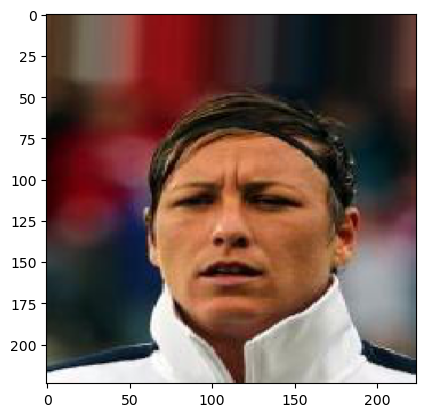

('Prediction: Male', 'Certainty: 92.99%')


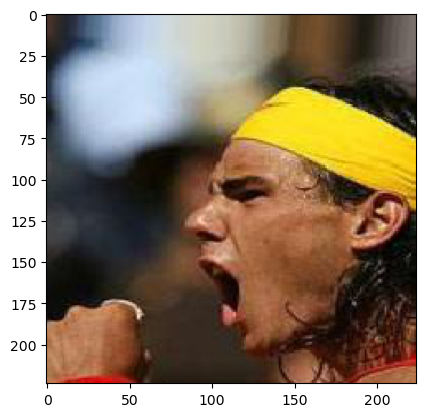

('Prediction: Female', 'Certainty: 56.32%')


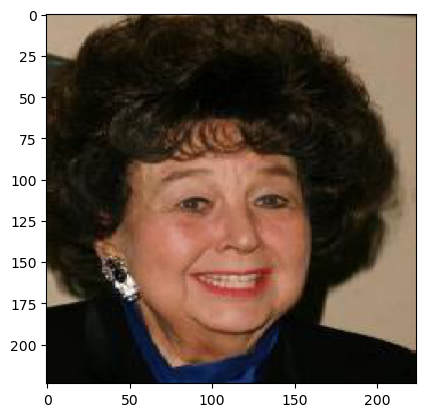

('Prediction: Male', 'Certainty: 66.53%')


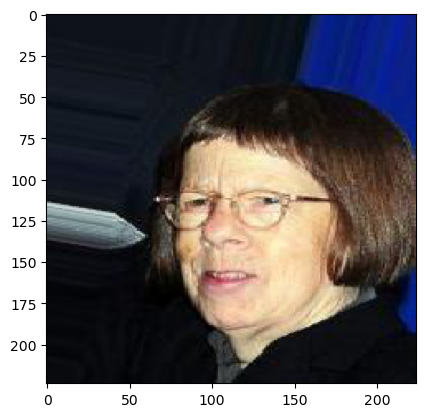

('Prediction: Male', 'Certainty: 99.39%')


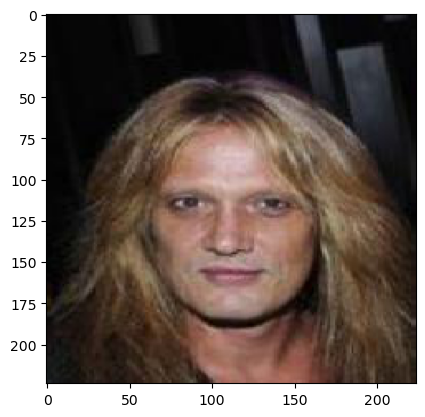

('Prediction: Female', 'Certainty: 93.72%')


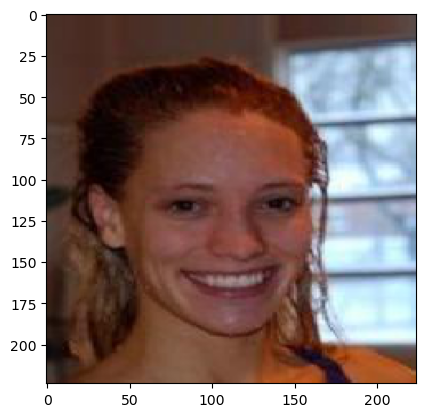

('Prediction: Male', 'Certainty: 62.69%')


In [651]:
for i in mismatch_indices:
    print(make_prediction(i, True))

Note that there are 3 or 4 instances here where the predicted label is actually correct compared with the ground truth - these simply represent cases of mis-labelling.

Based on this observation, the **true model accuracy is therefore likely slightly higher** than that reported by predicting on the test set.

### Getting the model to classify me!

#### Importing an image of myself
Continuing with using a generator as well as the variables "test_images" and "predictions" so that a new "make_prediction()" function doesn't need to be defined.

In [258]:
me = os.path.join(local_directory, 'me')

me_datagen = ImageDataGenerator(rescale=1./255)

me_generator = me_datagen.flow_from_directory(
    me,
    target_size=(image_size, image_size),
    batch_size=1,
    class_mode='binary')

test_images = me_generator.next()[0]
predictions = model.predict(test_images)

Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 118ms/step


#### Making prediction

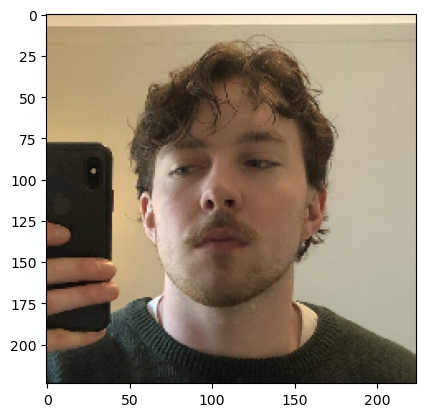

('Prediction: Male', 'Certainty: 96.04%')

In [259]:
make_prediction(0, True)

This prediction is accurate.

<!-- [[Conclusions]] -->
## Conclusions

By comparing three different convolutional bases in their contribution toward accurate facial gender classification, we have clearly highlighted the differences in efficacy between the approaches. The differential predictive performance observed aligns with initial predictions based upon the principles of transfer learning.

Given the somewhat limited dataset, the **CNNs performed drastically better when built with a pre-trained base than when built from scratch, i.e., with a custom, untrained base**. This comes as a pre-trained base comes with weights learned from training on a vast dataset, thus is equipped from the start to extract useful features for the classification task. Meanwhile, an untrained convolutional base is simply unable to learn such effective feature extraction from such a comparitively small dataset.

Further, **implementing a VGGFace pre-trained base rather than VGG16 resulted in the highest predictive accuracy**. Here, we achieved an impressive **accuracy score of 97.07%** (in addition to achieving **equal precision and recall**). This comes as VGGFace is trained for feature extraction on a task more similar than VGG16 to that of this project. As a result, the classifier is supplied with more pertinent information for the task at hand, and so can execute its job more effectively.

It was found through subsequent investigation that several test set images were evidently mis-labelled, and so **the true accuracy and F1 score of the models are likely higher than what was reported**.

## Thank you for reading!